In [2]:
#import dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn.cluster import KMeans

In [3]:
#load dataset
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')

In [4]:
#Create copy of train and test
traincopy = train.copy()
testcopy = test.copy()

In [5]:
def falg_func(x):
    #flag function
    if x==1:
        return 1
    elif x==2:
        return 2
    elif x==3:
        return 3
    elif x==4:
        return 4
    else:
        return 0
    
def season_map(x):
    if (x == 12 or x==  1 or  x ==2):
        return 1
    if (x == 3 or x== 4  or  x ==5):
        return 2
    if (x == 6 or x==  7 or  x ==8):
        return 3
    if (x == 9 or x==  10 or  x ==11):
        return 4

### Preprocessing

In [6]:
#calculate GHI 
ghi_estmates = train['Clearsky DNI']*np.cos(train['Solar Zenith Angle']*np.pi/180)+train['Clearsky DHI']

In [7]:
#concat train and test data
train['Phase'] = 'train'
test['Phase'] = 'test'
alldf = pd.concat([train,test],axis=0)

In [8]:
def preprocessing(train):
    #TIME features (year montd day and time)
    train['time'] = pd.to_datetime(train[['Year','Month','Day','Hour','Minute']])

    #diff between temp and due point  ~ 
    #he smaller the difference between the temp and the dew_point, the higher the RH
    train['dewpoint-temp'] = train['Temperature']-train['Dew Point']

    #RelativeHumidity and temp
    train['RHxTemp'] = train['Relative Humidity']*train['Temperature']

    #Relative Humidity Index(RHI)
    train['RHI'] = 0.8*train['Temperature']+train['Relative Humidity']/100*(train['Temperature']-14.4)+46
    
    #flag function
    train['Fill Flag'] = train['Fill Flag'].apply(falg_func)

    #pressure class
    train['Pressure_class'] =pd.cut(train['Pressure'],bins=[0,999,1008,1013,1040],labels=[0,1,2,3])

    #wind directions class 
    train['WindDirection_Class'] = pd.cut(train['Wind Direction'],bins=8,labels=[1,2,3,4,5,6,7,8])

    #sine transform of wind direction
    train['WindDirection_Sine'] = (np.sin(train['Wind Direction']*(np.pi/180)))

    #outliers - Cloudtype 10 replace with 0
    train['Cloud Type'][train['Cloud Type']==10] = 0
    return train

In [9]:
# #preprocessing for train and test data
# train = preprocessing(train)
# test = preprocessing(test)

In [10]:
#preprocessing for train and test data
alldf = preprocessing(alldf)

#split the data into train and test
train = alldf[alldf['Phase']=='train']
test = alldf[alldf['Phase']=='test']

In [11]:
def iqr_range(value):
    q1 = value.quantile(0.25)
    q3 = value.quantile(0.75)
    iqr = q3 - q1
    return q1-1.5*iqr,q3+1.5*iqr

<AxesSubplot:xlabel='time', ylabel='Clearsky DHI'>

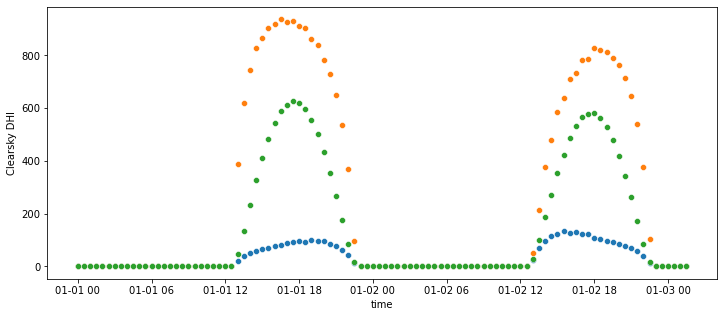

In [12]:
#visualize each target features
plt.figure(figsize=(12,5))
subdf = train[:100]
sns.scatterplot(data=subdf,x='time',y='Clearsky DHI')
sns.scatterplot(data=subdf,x='time',y='Clearsky DNI')
sns.scatterplot(data=subdf,x='time',y='Clearsky GHI')

* The day and night time periods
* There might be some correlation between target varibles (we found the equation for GHI)

* a region with a temperature of 18° and relative humidity of 40% is considered too dry whereas the region with 23° temperature and 70% relative humidity comes in the range of too moist regions. The regions between these two extremes are acceptable such as regions with 24° temperature and 50% humidity. In this way, their relationship affects the region.

* Relation between pressure and clouds

## Feature Engineering

In [13]:
def feature_engineering(train):
    #Seasons
    train['Season'] =  train['Month'].apply(lambda x:season_map(x))
    
    #Mean Humidity ZeningAngle WindDire by Hour and Minute
    train[['RelHumid_HourMinute','ZenithAng_HourMinute','WindDir_HourMinute']] =\
            train.groupby(['Hour','Minute'])['Relative Humidity', 'Solar Zenith Angle','Wind Direction'].transform('mean')

    #Mean Humidity ZeningAngle WindDire Temperature by Year and Month
    train[['RelHumid_YearMonth','WindDir_YearMonth','Temp_YearMonth']] =\
                train.groupby(['Year','Month'])['Relative Humidity','Wind Direction','Temperature'].transform('mean')

    #Mean Humidity ZeningAngle WindDire Temperature by Year and Month
    train[['RelHumid_SeasonYear','WindDir_SeasonYear','Temp_SeasonYear']] =\
                train.groupby(['Season','Year'])['Relative Humidity','Wind Direction','Temperature'].transform('mean')

    # Delta (diff)
    #change in Humidity
    train['delta_RelativeHumidity'] = train['Relative Humidity'].diff()
    #change in Temperature
    train['delta_Temperature'] = train['Temperature'].diff()
    #change in Dew Point
    train['delta_DewPoint'] = train['Dew Point'].diff()
    #change in Precipitable Water
    train['delta_PrecipWater'] = train['Precipitable Water'].diff()
    #change in Wind Speed
    train['delta_WindSpeed'] = train['Wind Speed'].diff()

    #Cloud Types and Pressure Class
    train[['CloudPressure_RelaHumidity', 'CloudPressure_PrecWater','CloudPressure_DewPoint','CloudPressure_Temp']] =\
    train.groupby(['Pressure_class','Cloud Type'])['Relative Humidity', 'Precipitable Water','Dew Point','Temperature'].transform('mean')
    
    return train

In [14]:
#feature engineering 
alldf = feature_engineering(alldf)
#split the data into train and test
train = alldf[alldf['Phase']=='train']
test = alldf[alldf['Phase']=='test']

#drop nan obs values in moving averages (drop entire row)
train = train.dropna(axis=0).reset_index(drop=True)
alldf = pd.concat([train,test],axis=0)

In [15]:
num_feats = ['Temperature','Pressure', 'Relative Humidity', 'Solar Zenith Angle',
'Precipitable Water', 'Wind Direction', 'Wind Speed', 'Fill Flag',
'ZenithAng_HourMinute', 'WindDir_HourMinute', 'RelHumid_YearMonth',
'WindDir_YearMonth', 'Temp_YearMonth', 'RelHumid_SeasonYear',
'WindDir_SeasonYear', 'Temp_SeasonYear', 'delta_RelativeHumidity',
'delta_Temperature', 'delta_DewPoint', 'delta_PrecipWater',
'delta_WindSpeed',
# 'MA_RelativeHumidity', 'MA_Temperature','MA_DewPoint', 
# 'MA_PrecipitableWater', 'MA_WindSpeed','MA_WindDirection',
'CloudPressure_RelaHumidity',
'CloudPressure_PrecWater', 'CloudPressure_DewPoint',
'CloudPressure_Temp']

In [16]:
#pca components as new features
pca = decomposition.IncrementalPCA(n_components=10)
emb = pca.fit_transform(alldf[num_feats].values)

for i in range(emb.shape[1]):
    alldf[f'pca_{i+1}'] = emb[:, i]

In [17]:
#try pca
avoidcols = ['Clearsky DNI','Clearsky DHI','Clearsky GHI','time','Phase']
trainX = train.drop(columns=avoidcols)
avoidcolumns_train = train[avoidcols]

testX = test.drop(columns=avoidcols)
avoidcolumns_test = test[avoidcols]

# scale trainX using StandardScaler
sc = StandardScaler()
train_pca = sc.fit_transform(trainX)
test_pca = sc.transform(testX)

#pca with 95% variance
pca = PCA(n_components = 0.99)
 
pca_Train = pca.fit_transform(train_pca)
pca_Test = pca.transform(test_pca)

#variance
explained_variance = pca.explained_variance_ratio_
pcadf = pd.DataFrame(pca.components_, columns=list(trainX.columns))

#crate dataframe of pca table
pca_Train = pd.DataFrame(pca_Train)
pca_Test = pd.DataFrame(pca_Test)

#concat pca table and avoidcolumns
pca_Train = pd.concat([pca_Train,avoidcolumns_train],axis=1)
pca_Test = pd.concat([pca_Test,avoidcolumns_train],axis=1)

In [18]:
# Fit the KMeans model to create cluster labels
kmeans = KMeans(n_clusters=2, n_init=50, random_state=0)
alldf['cluster']=  kmeans.fit_predict(alldf[num_feats].values)

In [19]:
#split the features into train and test
train = alldf[alldf['Phase']=='train']
test = alldf[alldf['Phase']=='test']

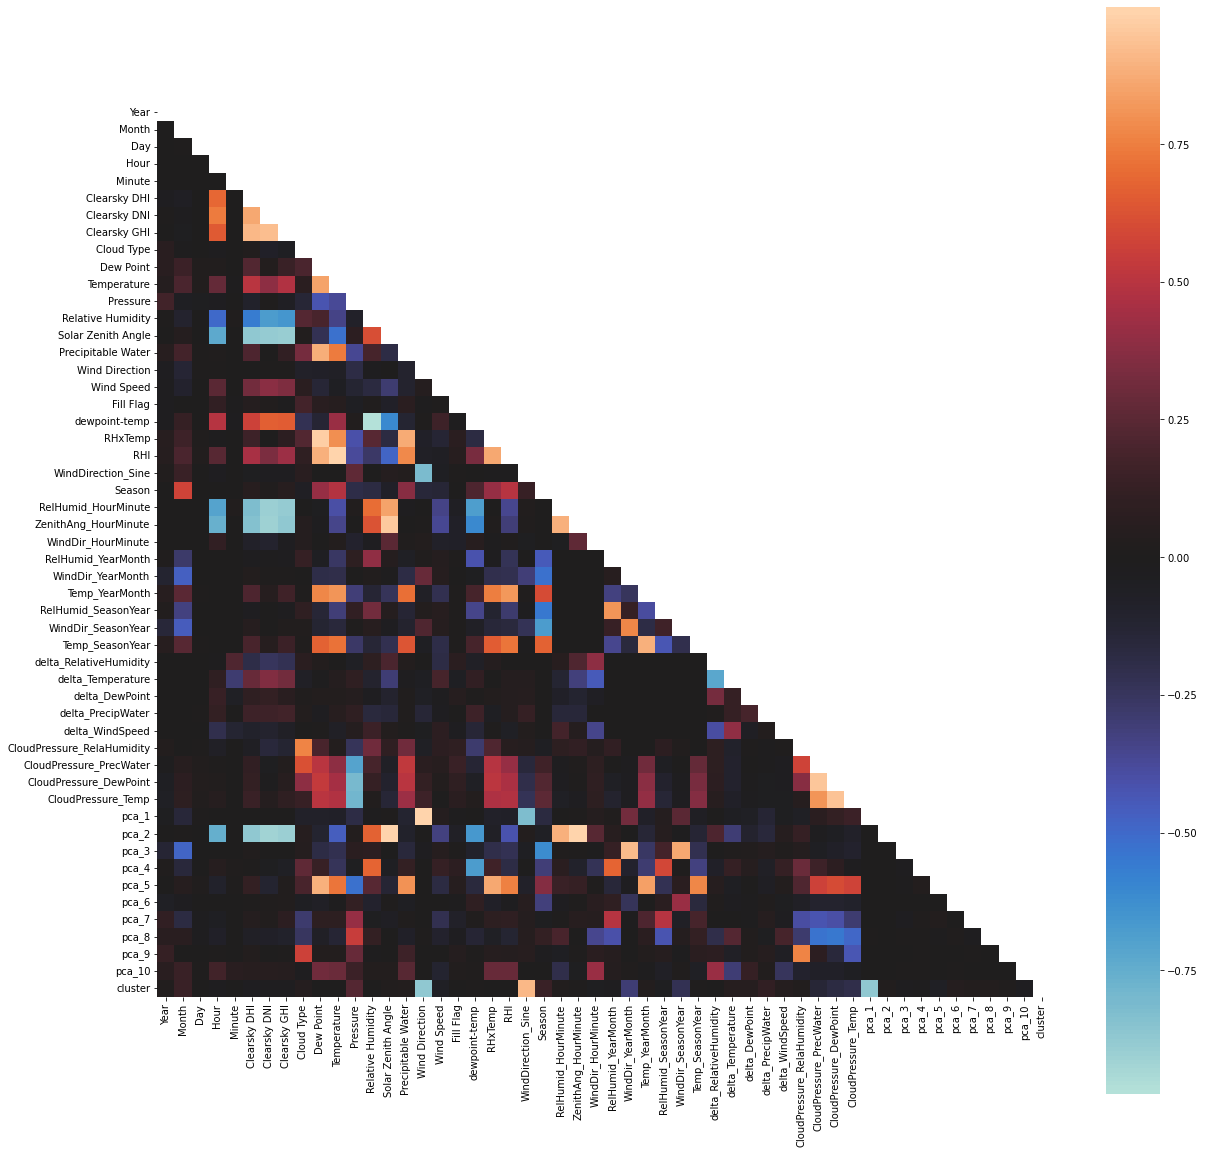

In [20]:
#Correlation
corr = train.corr()
matrix = np.triu(corr)
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot = False,square=True,mask=matrix,center=0,linewidths=0)
plt.show()

In [21]:
# Create correlation matrix
targets = ['Clearsky DNI','Clearsky DHI','Clearsky GHI']
corr_matrix = train.drop(targets,axis=1).corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [22]:
alldf.drop(columns=to_drop,inplace=True)

# Modelling

In [23]:
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import optuna
from optuna.samplers import TPESampler

In [24]:
#split numerical and categorical data
drop_feats = ['time','Day','Minute']  
cat_feats = [ 'Hour', 'Cloud Type','Fill Flag','Pressure_class','WindDirection_Class']

num_feats = [feat for feat in alldf.columns if (feat not in cat_feats and feat not in  drop_feats)]
num_feats.remove('Phase')

#get dummies for categorical features and drop drop_feats
finaldf =  pd.get_dummies(alldf,columns=cat_feats)
finaldf = finaldf.drop(columns=drop_feats)

#split the data into train and test
traindata = finaldf[finaldf['Phase']=='train']
testdata = finaldf[finaldf['Phase']=='test']
traindata.drop(columns='Phase',inplace=True)
testdata.drop(columns='Phase',inplace=True)

In [25]:
#Parameter tuning
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalidation = lgb.Dataset(X_test,label=y_test)
#     watchlist = [dvalidation]
    param = {
        'objective': 'regression',
        'metric': 'RMSE',
        "n_estimators": trial.suggest_int('n_estimators',50,400),
        'learning_rate': trial.suggest_loguniform('learning_rate',0.01, 0.1),
        'lambda_l1': trial.suggest_loguniform('lambda_l1',5, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 5, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 30, 80),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3,0.7),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 0.7),
        'bagging_freq': trial.suggest_int('bagging_freq', 4, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
    }
    lgb_model = lgb.train(param,
                    train_set=dtrain,
                    valid_sets=[dtrain,dvalidation],
                    early_stopping_rounds=50)
    
    y_pred = lgb_model.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    return score

In [26]:
def light_gbm_model_run(train_x, train_y, validation_x, validation_y,best_params_DHI):
    params = best_params_DHI
    # Given its a regression case, I am using the RMSE as the metric.
    lg_train = lgb.Dataset(train_x, label=train_y)
    lg_validation = lgb.Dataset(validation_x, label=validation_y)
    evals_result_lgbm = {}

    model_light_gbm = lgb.train(params, train_set= lg_train,
                      valid_sets=[lg_train, lg_validation],
                      early_stopping_rounds=10,
                      verbose_eval=50,
                      evals_result=evals_result_lgbm )

    return model_light_gbm

### Estimate DHI

In [27]:
# target = 'Clearsky DHI'
# targets = ['Clearsky DHI','Clearsky DNI','Clearsky GHI']
# df_DHI = traindata.drop(columns = ['Clearsky DNI','Clearsky GHI'])
# X = df_DHI.drop(columns=target,axis=1)
# y = df_DHI[target]

# study_DHI = optuna.create_study(sampler=TPESampler(), direction="minimize")
# study_DHI.optimize(objective, n_trials=20, timeout=600) # Run for 10 minutes
# print("Number of completed trials: {}".format(len(study_DHI.trials)))
# print("Best trial:")
# trial_DHI = study_DHI.best_trial

# print("\tBest Score: {}".format(trial_DHI.value))
# print("\tBest Params: ")
# for key, value in trial_DHI.params.items():
#     print("    {}: {}".format(key, value))

# #best parameters
# best_params_DHI = trial_DHI.params

In [28]:
best_params_DHI = {'n_estimators': 500,
                 'learning_rate': 0.0225454809500622,
                 'lambda_l1': 4.205566763888546,
                 'lambda_l2': 4.046592151495001,
                 'num_leaves': 70,
                 'feature_fraction': 0.4436911802030728,
                 'bagging_fraction': 0.44244658828413636,
                 'bagging_freq': 8,
                 'min_child_samples': 40}

In [29]:
#train using best params
target = 'Clearsky DHI'
targets = ['Clearsky DHI','Clearsky DNI','Clearsky GHI']
df_DHI = traindata.drop(columns = ['Clearsky DNI','Clearsky GHI'])
X = df_DHI.drop(columns=target,axis=1)
y = df_DHI[target]

# Split the train data into train and validation
x_train,x_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2,random_state=1)

#Run Lightgbm code 
lgbm_DHI = light_gbm_model_run(x_train, y_train, x_valid, y_valid,best_params_DHI)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5722
[LightGBM] [Info] Number of data points in the train set: 140236, number of used features: 87
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 53.124840
Training until validation scores don't improve for 10 rounds
[50]	training's l2: 742.406	valid_1's l2: 740.856
[100]	training's l2: 291.917	valid_1's l2: 297.352
[150]	training's l2: 211.2	valid_1's l2: 219.874
[200]	training's l2: 181.293	valid_1's l2: 192.703
[250]	training's l2: 164.971	valid_1's l2: 178.605
[300]	training's l2: 153.777	valid_1's l2: 169.305
[350]	training's l2: 144.399	valid_1's l2: 162.015
[400]	training's l2: 137.155	valid_1's l2: 156.678
[450]	training's l2: 130.92

In [ ]:
#training's l2: 158.518	valid_1's l2: 168.865

#training's l2: 134.214	valid_1's l2: 153.311

In [30]:
#Predict for test data
test_pred = lgbm_DHI.predict(testdata.drop(columns=targets))
test[target] = test_pred

### Estimate DNI

In [ ]:
# target = 'Clearsky DNI'
# targets = ['Clearsky DHI','Clearsky DNI','Clearsky GHI']
# df_DNI = traindata.drop(columns = ['Clearsky DHI','Clearsky GHI'])
# X = df_DNI.drop(columns=target,axis=1)
# y = df_DNI[target]

# study_DNI = optuna.create_study(sampler=TPESampler(), direction="minimize")
# study_DNI.optimize(objective, n_trials=20, timeout=600) # Run for 10 minutes
# print("Number of completed trials: {}".format(len(study_DNI.trials)))
# print("Best trial:")
# trial_DNI = study_DNI.best_trial

# print("\tBest Score: {}".format(trial_DNI.value))
# print("\tBest Params: ")
# for key, value in trial_DNI.params.items():
#     print("    {}: {}".format(key, value))

# #best parameters
# best_params_DNI = trial_DNI.params

In [31]:
best_params_DNI  =  {'n_estimators': 500,
                     'learning_rate': 0.05556381813060932,
                     'lambda_l1': 5.750422461759491,
                     'lambda_l2': 5.895205653882822,
                     'num_leaves': 25,
                     'feature_fraction': 0.642875048188268,
                     'bagging_fraction': 0.625010561791788,
                     'bagging_freq': 5,
                     'min_child_samples':25}

In [32]:
#train using best params
target = 'Clearsky DNI'
targets = ['Clearsky DHI','Clearsky DNI','Clearsky GHI']
df_DNI = traindata.drop(columns = ['Clearsky DHI','Clearsky GHI'])
X = df_DNI.drop(columns=target,axis=1)
y = df_DNI[target]

# Split the train data into train and validation
x_train,x_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2,random_state=1)

#Run Lightgbm code 
lgbm_DNI = light_gbm_model_run(x_train, y_train, x_valid, y_valid,best_params_DNI)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5722
[LightGBM] [Info] Number of data points in the train set: 140236, number of used features: 87
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 330.074410
Training until validation scores don't improve for 10 rounds
[50]	training's l2: 2179.2	valid_1's l2: 2180.46
[100]	training's l2: 1330.73	valid_1's l2: 1334.49
[150]	training's l2: 1194.49	valid_1's l2: 1211.95
[200]	training's l2: 1117.98	valid_1's l2: 1150.48
[250]	training's l2: 1059.96	valid_1's l2: 1104.55
[300]	training's l2: 1014.38	valid_1's l2: 1073.23
[350]	training's l2: 970.829	valid_1's l2: 1040.56
[400]	training's l2: 934.917	valid_1's l2: 1014.41
[450]	training's l2: 905.

In [33]:
 #training's l2: 973.092	valid_1's l2: 1042.6
    
    # 901.308	valid_1's l2: 966.681

In [34]:
#Predict for test data
test_pred = lgbm_DNI.predict(testdata.drop(columns=targets))
test[target] = test_pred

### Estimate GHI

In [35]:
predictiondf = test.copy()
predictiondf['Clearsky GHI'] = predictiondf['Clearsky DNI']*np.cos(predictiondf['Solar Zenith Angle']*np.pi/180)+predictiondf['Clearsky DHI']

In [36]:
#save output
predictiondf[['Clearsky DHI','Clearsky DNI','Clearsky GHI']].to_csv('lgb02.csv',index=False)

In [37]:
predictiondf

,Year,Month,Day,Hour,Minute,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Dew Point,Temperature,Pressure,Relative Humidity,Solar Zenith Angle,Precipitable Water,Wind Direction,Wind Speed,Fill Flag,Phase,time,dewpoint-temp,RHxTemp,RHI,Pressure_class,WindDirection_Class,WindDirection_Sine,Season,RelHumid_HourMinute,ZenithAng_HourMinute,WindDir_HourMinute,RelHumid_YearMonth,WindDir_YearMonth,Temp_YearMonth,RelHumid_SeasonYear,WindDir_SeasonYear,Temp_SeasonYear,delta_RelativeHumidity,delta_Temperature,delta_DewPoint,delta_PrecipWater,delta_WindSpeed,CloudPressure_RelaHumidity,CloudPressure_PrecWater,CloudPressure_DewPoint,CloudPressure_Temp,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,cluster
0,2019,1,1,0,0,0.116419,4.506031,-1.142989,7,18.4,18.8,1008,97.70,106.23,3.5,190.0,2.3,0,test,2019-01-01 00:00:00,0.4,1836.760,65.33880,1,5,-0.173648,1,79.949751,94.843791,185.803361,84.986001,231.309140,9.086694,85.627225,190.339352,11.303241,0.86,-0.4,-0.3,-0.2,0.2,86.266772,3.776886,17.397043,20.505021,5.448976,19.533676,37.083741,13.535638,-6.178825,-24.655640,-2.012267,-5.145005,4.315680,6.743397,0
1,2019,1,1,0,30,0.794498,3.367070,-0.486419,3,18.4,18.6,1008,98.92,112.36,3.5,187.0,2.5,0,test,2019-01-01 00:30:00,0.2,1839.912,65.03464,1,5,-0.121869,1,82.858133,100.996679,185.746851,84.986001,231.309140,9.086694,85.627225,190.339352,11.303241,1.22,-0.2,0.0,0.0,0.2,80.323052,3.861781,18.595190,23.191819,2.547011,28.157838,37.269518,11.936116,-5.851543,-24.466712,-0.586098,-5.122653,-1.877787,7.460744,0
2,2019,1,1,1,0,-0.822748,1.010231,-1.306028,3,18.2,18.5,1008,98.35,118.58,3.5,184.0,2.8,0,test,2019-01-01 01:00:00,0.3,1819.475,64.83235,1,5,-0.069756,1,82.137062,107.103435,185.226836,84.986001,231.309140,9.086694,85.627225,190.339352,11.303241,-0.57,-0.1,-0.2,0.0,0.3,80.323052,3.861781,18.595190,23.191819,-0.396330,36.449435,37.450565,9.555831,-6.230005,-24.067957,-0.258326,-5.637395,-1.872783,6.481686,0
3,2019,1,1,1,30,0.487885,0.851476,0.001204,3,18.2,18.3,1008,99.58,124.86,3.5,185.0,3.0,0,test,2019-01-01 01:30:00,0.1,1822.314,64.52362,1,5,-0.087156,1,84.699109,113.103064,185.609211,84.986001,231.309140,9.086694,85.627225,190.339352,11.303241,1.23,-0.2,0.0,0.0,0.2,80.323052,3.861781,18.595190,23.191819,0.634921,45.187642,37.322949,8.636048,-6.123932,-23.903210,-0.098699,-6.115553,-1.772605,7.365922,0
4,2019,1,1,2,0,0.388685,0.037870,0.363741,0,18.0,18.0,1008,99.71,131.20,3.6,186.0,3.1,0,test,2019-01-01 02:00:00,0.0,1794.780,63.98956,1,5,-0.104528,1,84.381840,118.965925,186.537889,84.986001,231.309140,9.086694,85.627225,190.339352,11.303241,0.13,-0.3,-0.2,0.1,0.1,73.196342,2.888792,15.020345,21.345312,1.662940,53.531063,37.140778,6.027185,-8.140445,-23.127913,3.879294,-3.175956,-6.803571,8.769347,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,2019,12,31,21,30,49.519910,653.434463,186.603413,0,5.6,11.1,1006,68.64,77.89,0.8,276.0,2.2,0,test,2019-12-31 21:30:00,5.5,761.904,52.61488,1,7,-0.994522,1,64.774927,64.308810,192.141997,84.067258,163.950269,11.143548,85.627225,190.339352,11.303241,7.32,-1.7,0.1,0.0,-0.5,73.196342,2.888792,15.020345,21.345312,85.046762,-26.939950,-26.308501,7.991026,-17.212432,18.589922,0.213406,-5.394147,-5.014194,3.402639,0
17516,2019,12,31,22,0,35.478702,477.829302,93.214761,0,5.7,9.3,1006,78.31,83.06,0.8,274.0,1.7,0,test,2019-12-31 22:00:00,3.6,728.283,49.44619,1,7,-0.997564,1,68.183811,70.277760,190.299178,84.067258,163.950269,11.143548,85.627225,190.339352,11.303241,9.67,-1.8,0.1,0.0,-0.5,73.196342,2.888792,15.020345,21.345312,83.077563,-16.909050,-25.546211,14.451053,-14.828450,17.250919,-0.537627,-2.681423,-5.846738,3.244984,0
17517,2019,12,31,22,30,8.685278,130.779301,12.473746,0,5.7,8.5,1006,82.64,88.34,0.8,273.0,1.8,0,test,2019-12-31 22:30:00,2.8,702.440,47.92424,1,7,-0.998630,1,72.577523,76.338937,190.1